In [ ]:
import sys


from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer 


import cv2 as cv
import warnings
import matplotlib.cbook
import matplotlib.pyplot as plt

from time import time

import random
import bisect
import heapq


warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from operator import attrgetter

In [ ]:
!mkdir output

In [ ]:
def dissimilarity_measure(first_piece, second_piece, orientation="LR"):
    rows, columns, _ = first_piece.shape()
    color_difference = None


    if orientation == "LR":
        color_difference = (
            first_piece[:rows, columns - 1, :] - second_piece[:rows, 0, :]
        )

    if orientation == "TD":
        color_difference = (
            first_piece[rows - 1, :columns, :] - second_piece[0, :columns, :]
        )

    squared_color_difference = np.power(color_difference / 255.0, 2)
    color_difference_per_row = np.sum(squared_color_difference, axis=1)
    total_difference = np.sum(color_difference_per_row, axis=0)

    value = np.sqrt(total_difference)

    return value

In [ ]:
class Plot(object):
    def __init__(self, image, title="Initial problem"):
        aspect_ratio = image.shape[0] / float(image.shape[1])

        width = 8
        height = width * aspect_ratio
        fig = plt.figure(figsize=(width, height), frameon=False)

        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 0.9])
        ax.set_axis_off()
        fig.add_axes(ax)

        self._current_image = ax.imshow(image, aspect="auto", animated=True)
        self.show_fittest(image, title)

    def show_fittest(self, image, title):
        plt.suptitle(title, fontsize=20)
        self._current_image.set_data(image)
        plt.draw()

        plt.pause(0.2)

    def save(self, image, title):
        plt.suptitle(title, fontsize=20)
        self._current_image.set_data(image)
        plt.savefig("output/" + title + ".jpg")

In [ ]:
def print_progress(iteration, total, prefix="", suffix="", decimals=1, bar_length=50):
    """Call in a loop to create terminal progress bar"""
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = "\033[32m█\033[0m" * filled_length + "\033[31m-\033[0m" * (
        bar_length - filled_length
    )

    sys.stdout.write(
        "\r{0: <16} {1} {2}{3} {4}".format(prefix, bar, percents, "%", suffix)
    )

    if iteration == total:
        sys.stdout.write("\n")
    sys.stdout.flush()

In [ ]:
def roulette_selection(population, elites=4):
  
    fitness_values = [individual.fitness for individual in population]
    probability_intervals = [
        sum(fitness_values[: i + 1]) for i in range(len(fitness_values))
    ]

    def select_individual():
      
        random_select = random.uniform(0, probability_intervals[-1])
        selected_index = bisect.bisect_left(probability_intervals, random_select)
        return population[selected_index]

    selected = []
    for i in range(len(population) - elites):
        first, second = select_individual(), select_individual()
        selected.append((first, second))

    return selected

In [ ]:
class Piece(object):
    def __init__(self, image, index):
        self.image = image[:]
        self.id = index

    def __getitem__(self, index):
        return self.image.__getitem__(index)

    def size(self):
        return self.image.shape[0]

    def shape(self):
        return self.image.shape


In [ ]:
def flatten_image(image, piece_size, indexed=False):

    rows, columns = image.shape[0] // piece_size, image.shape[1] // piece_size
    pieces = []

    # Crop pieces from original image
    for y in range(rows):
        for x in range(columns):
            left, top, w, h = (
                x * piece_size,
                y * piece_size,
                (x + 1) * piece_size,
                (y + 1) * piece_size,
            )
            piece = np.empty((piece_size, piece_size, image.shape[2]))
            piece[:piece_size, :piece_size, :] = image[top:h, left:w, :]
            pieces.append(piece)

    if indexed:
        pieces = [Piece(value, index) for index, value in enumerate(pieces)]

    return pieces, rows, columns


def assemble_image(pieces, rows, columns):

    vertical_stack = []
    for i in range(rows):
        horizontal_stack = []
        for j in range(columns):
            horizontal_stack.append(pieces[i * columns + j])
        vertical_stack.append(np.hstack(horizontal_stack))
    return np.vstack(vertical_stack).astype(np.uint8)

In [ ]:
class ImageAnalysis(object):

    dissimilarity_measures = {}
    best_match_table = {}

    @classmethod
    def analyze_image(cls, pieces):
        for piece in pieces:
            cls.best_match_table[piece.id] = {"T": [], "R": [], "D": [], "L": []}

        def update_best_match_table(first_piece, second_piece):
            measure = dissimilarity_measure(first_piece, second_piece, orientation)
            cls.put_dissimilarity(
                (first_piece.id, second_piece.id), orientation, measure
            )
            cls.best_match_table[second_piece.id][orientation[0]].append(
                (first_piece.id, measure)
            )
            cls.best_match_table[first_piece.id][orientation[1]].append(
                (second_piece.id, measure)
            )

        # Calculate dissimilarity measures and best matches for each piece.
        iterations = len(pieces) - 1
        for first in range(iterations):
            print_progress(first, iterations - 1, prefix="=== Analyzing image:")
            for second in range(first + 1, len(pieces)):
                for orientation in ["LR", "TD"]:
                    update_best_match_table(pieces[first], pieces[second])
                    update_best_match_table(pieces[second], pieces[first])

        for piece in pieces:
            for orientation in ["T", "L", "R", "D"]:
                cls.best_match_table[piece.id][orientation].sort(key=lambda x: x[1])

    @classmethod
    def put_dissimilarity(cls, ids, orientation, value):
        if ids not in cls.dissimilarity_measures:
            cls.dissimilarity_measures[ids] = {}
        cls.dissimilarity_measures[ids][orientation] = value

    @classmethod
    def get_dissimilarity(cls, ids, orientation):
        return cls.dissimilarity_measures[ids][orientation]

    @classmethod
    def best_match(cls, piece, orientation):
        return cls.best_match_table[piece][orientation][0][0]

In [ ]:
class Individual(object):
    FITNESS_FACTOR = 1000

    def __init__(self, pieces, rows, columns, shuffle=True):
        self.pieces = pieces[:]
        self.rows = rows
        self.columns = columns
        self._fitness = None

        if shuffle:
            np.random.shuffle(self.pieces)

        # Map piece ID to index in Individual's list
        self._piece_mapping = {
            piece.id: index for index, piece in enumerate(self.pieces)
        }

    def __getitem__(self, key):
        return self.pieces[key * self.columns : (key + 1) * self.columns]

    @property
    def fitness(self):
        if self._fitness is None:
            fitness_value = 1 / self.FITNESS_FACTOR
            # For each two adjacent pieces in rows
            for i in range(self.rows):
                for j in range(self.columns - 1):
                    ids = (self[i][j].id, self[i][j + 1].id)
                    fitness_value += ImageAnalysis.get_dissimilarity(
                        ids, orientation="LR"
                    )
            # For each two adjacent pieces in columns
            for i in range(self.rows - 1):
                for j in range(self.columns):
                    ids = (self[i][j].id, self[i + 1][j].id)
                    fitness_value += ImageAnalysis.get_dissimilarity(
                        ids, orientation="TD"
                    )

            self._fitness = self.FITNESS_FACTOR / fitness_value

        return self._fitness

    def piece_size(self):
        return self.pieces[0].size

    def piece_by_id(self, identifier):
        return self.pieces[self._piece_mapping[identifier]]

    def to_image(self):
        pieces = [piece.image for piece in self.pieces]
        return assemble_image(pieces, self.rows, self.columns)

    def edge(self, piece_id, orientation):
        edge_index = self._piece_mapping[piece_id]

        if (orientation == "T") and (edge_index >= self.columns):
            return self.pieces[edge_index - self.columns].id

        if (orientation == "R") and (edge_index % self.columns < self.columns - 1):
            return self.pieces[edge_index + 1].id

        if (orientation == "D") and (edge_index < (self.rows - 1) * self.columns):
            return self.pieces[edge_index + self.columns].id

        if (orientation == "L") and (edge_index % self.columns > 0):
            return self.pieces[edge_index - 1].id

In [ ]:
SHARED_PIECE_PRIORITY = -10
BUDDY_PIECE_PRIORITY = -1


class Crossover(object):
    def __init__(self, first_parent, second_parent):
        self._parents = (first_parent, second_parent)
        self._pieces_length = len(first_parent.pieces)
        self._child_rows = first_parent.rows
        self._child_columns = first_parent.columns

        # Borders of growing kernel
        self._min_row = 0
        self._max_row = 0
        self._min_column = 0
        self._max_column = 0

        self._kernel = {}
        self._taken_positions = set()

        # Priority queue
        self._candidate_pieces = []

    def child(self):
        pieces = [None] * self._pieces_length

        for piece, (row, column) in self._kernel.items():
            index = (row - self._min_row) * self._child_columns + (
                column - self._min_column
            )
            pieces[index] = self._parents[0].piece_by_id(piece)

        return Individual(pieces, self._child_rows, self._child_columns, shuffle=False)

    def run(self):
        self._initialize_kernel()

        while len(self._candidate_pieces) > 0:
            _, (position, piece_id), relative_piece = heapq.heappop(
                self._candidate_pieces
            )

            if position in self._taken_positions:
                continue

            if piece_id in self._kernel:
                self.add_piece_candidate(relative_piece[0], relative_piece[1], position)
                continue

            self._put_piece_to_kernel(piece_id, position)

    def _initialize_kernel(self):
        root_piece = self._parents[0].pieces[
            int(random.uniform(0, self._pieces_length))
        ]
        self._put_piece_to_kernel(root_piece.id, (0, 0))

    def _put_piece_to_kernel(self, piece_id, position):
        self._kernel[piece_id] = position
        self._taken_positions.add(position)
        self._update_candidate_pieces(piece_id, position)

    def _update_candidate_pieces(self, piece_id, position):
        available_boundaries = self._available_boundaries(position)

        for orientation, position in available_boundaries:
            self.add_piece_candidate(piece_id, orientation, position)

    def add_piece_candidate(self, piece_id, orientation, position):
        shared_piece = self._get_shared_piece(piece_id, orientation)
        if self._is_valid_piece(shared_piece):
            self._add_shared_piece_candidate(
                shared_piece, position, (piece_id, orientation)
            )
            return

        buddy_piece = self._get_buddy_piece(piece_id, orientation)
        if self._is_valid_piece(buddy_piece):
            self._add_buddy_piece_candidate(
                buddy_piece, position, (piece_id, orientation)
            )
            return

        best_match_piece, priority = self._get_best_match_piece(piece_id, orientation)
        if self._is_valid_piece(best_match_piece):
            self._add_best_match_piece_candidate(
                best_match_piece, position, priority, (piece_id, orientation)
            )
            return

    def _get_shared_piece(self, piece_id, orientation):
        first_parent, second_parent = self._parents
        first_parent_edge = first_parent.edge(piece_id, orientation)
        second_parent_edge = second_parent.edge(piece_id, orientation)

        if first_parent_edge == second_parent_edge:
            return first_parent_edge

    def _get_buddy_piece(self, piece_id, orientation):
        first_buddy = ImageAnalysis.best_match(piece_id, orientation)
        second_buddy = ImageAnalysis.best_match(
            first_buddy, complementary_orientation(orientation)
        )

        if second_buddy == piece_id:
            for edge in [
                parent.edge(piece_id, orientation) for parent in self._parents
            ]:
                if edge == first_buddy:
                    return edge

    def _get_best_match_piece(self, piece_id, orientation):
        for piece, dissimilarity_measure in ImageAnalysis.best_match_table[piece_id][
            orientation
        ]:
            if self._is_valid_piece(piece):
                return piece, dissimilarity_measure

    def _add_shared_piece_candidate(self, piece_id, position, relative_piece):
        piece_candidate = (SHARED_PIECE_PRIORITY, (position, piece_id), relative_piece)
        heapq.heappush(self._candidate_pieces, piece_candidate)

    def _add_buddy_piece_candidate(self, piece_id, position, relative_piece):
        piece_candidate = (BUDDY_PIECE_PRIORITY, (position, piece_id), relative_piece)
        heapq.heappush(self._candidate_pieces, piece_candidate)

    def _add_best_match_piece_candidate(
        self, piece_id, position, priority, relative_piece
    ):
        piece_candidate = (priority, (position, piece_id), relative_piece)
        heapq.heappush(self._candidate_pieces, piece_candidate)

    def _available_boundaries(self, row_and_column):
        (row, column) = row_and_column
        boundaries = []

        if not self._is_kernel_full():
            positions = {
                "T": (row - 1, column),
                "R": (row, column + 1),
                "D": (row + 1, column),
                "L": (row, column - 1),
            }

            for orientation, position in positions.items():
                if position not in self._taken_positions and self._is_in_range(
                    position
                ):
                    self._update_kernel_boundaries(position)
                    boundaries.append((orientation, position))

        return boundaries

    def _is_kernel_full(self):
        return len(self._kernel) == self._pieces_length

    def _is_in_range(self, row_and_column):
        (row, column) = row_and_column
        return self._is_row_in_range(row) and self._is_column_in_range(column)

    def _is_row_in_range(self, row):
        current_rows = abs(min(self._min_row, row)) + abs(max(self._max_row, row))
        return current_rows < self._child_rows

    def _is_column_in_range(self, column):
        current_columns = abs(min(self._min_column, column)) + abs(
            max(self._max_column, column)
        )
        return current_columns < self._child_columns

    def _update_kernel_boundaries(self, row_and_column):
        (row, column) = row_and_column
        self._min_row = min(self._min_row, row)
        self._max_row = max(self._max_row, row)
        self._min_column = min(self._min_column, column)
        self._max_column = max(self._max_column, column)

    def _is_valid_piece(self, piece_id):
        return piece_id is not None and piece_id not in self._kernel


def complementary_orientation(orientation):
    return {"T": "D", "R": "L", "D": "T", "L": "R"}.get(orientation, None)

In [ ]:
class GeneticAlgorithm(object):

    TERMINATION_THRESHOLD = 100

    def __init__(self, image, piece_size, population_size, generations, elite_size=4):
        self._image = image
        self._piece_size = piece_size
        self._generations = generations
        self._elite_size = elite_size
        pieces, rows, columns = flatten_image(
            image, piece_size, indexed=True
        )
        self._population = [
            Individual(pieces, rows, columns) for _ in range(population_size)
        ]
        self._pieces = pieces

    # @jit(target_backend='cuda')
    def start_evolution(self, verbose = 1):
        print("=== Pieces:      {}\n".format(len(self._pieces)))

        plot = Plot(self._image)

        ImageAnalysis.analyze_image(self._pieces)

        fittest = None
        best_fitness_score = float("-inf")
        termination_counter = 0

        for generation in range(self._generations):
            img = self._best_individual().to_image();
            plot.save(img, str(generation))
            print_progress(
                generation, self._generations - 1, prefix="=== Solving puzzle: "
            )

            new_population = []

            # Elitism
            elite = self._get_elite_individuals(elites=self._elite_size)
            new_population.extend(elite)

            selected_parents = roulette_selection(
                self._population, elites=self._elite_size
            )

            for first_parent, second_parent in selected_parents:
                crossover = Crossover(first_parent, second_parent)
                crossover.run()
                child = crossover.child()
                new_population.append(child)

            fittest = self._best_individual()

            if fittest.fitness <= best_fitness_score:
                termination_counter += 1
            else:
                best_fitness_score = fittest.fitness

            if termination_counter == self.TERMINATION_THRESHOLD:
                print("\n\n=== GA terminated")
                print(
                    "=== There was no improvement for {} generations".format(
                        self.TERMINATION_THRESHOLD
                    )
                )
                return fittest

            self._population = new_population

            if verbose:
                plot.show_fittest(
                    fittest.to_image(),
                    "Generation: {} / {}".format(generation + 1, self._generations),
                )

        return fittest

    def _get_elite_individuals(self, elites):
        return sorted(self._population, key=attrgetter("fitness"))[-elites:]

    def _best_individual(self):
        return max(self._population, key=attrgetter("fitness"))

In [ ]:
def create_puzzle(image_path, output_path, piece_size):
    image = cv.imread(image_path)
    pieces, rows, columns = flatten_image(image, piece_size)

    # Randomize pieces in order to make puzzle
    np.random.shuffle(pieces)

    # Create puzzle by stacking pieces
    puzzle = assemble_image(pieces, rows, columns)

    cv.imwrite(output_path, puzzle)
    print(["Puzzle created with {} pieces".format(len(pieces))])

## 600 pieces

In [ ]:
create_puzzle("leaf.jpg", "puzzle.jpg", 200)

['Puzzle created with 600 pieces']


In [ ]:
# -------INPUT--------- #
input_image = "puzzle.jpg"
pixel_size = 200
GENERATIONS = 15
POPULATION = 600
verbose = 1


def show_image(img, title):
    Plot(img, title)
    plt.show()


=== Population:  600
=== Generations: 15
=== Piece size:  200 px
=== Pieces:      600



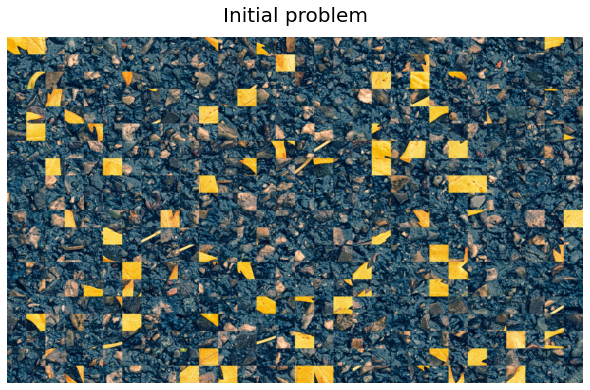

=== Analyzing image: ██████████████████████████████████████████████████ 100.0% 
=== Solving puzzle:  -------------------------------------------------- 0.0% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████---------------------------------------------- 7.1% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████------------------------------------------- 14.3% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████--------------------------------------- 21.4% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████------------------------------------ 28.6% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████-------------------------------- 35.7% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████----------------------------- 42.9% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████████------------------------- 50.0% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████████████--------------------- 57.1% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████████████████████████████████------------------ 64.3% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████████████████████████████████████-------------- 71.4% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████████████████████████████████----------- 78.6% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████████████████████████████████████------- 85.7% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████████████████████████████████---- 92.9% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████████████████████████████████████ 100.0% 


<Figure size 432x288 with 0 Axes>


=== Done in 145.322 s
=== Result saved as 'puzzle_solution.jpg'
=== Close figure to exit


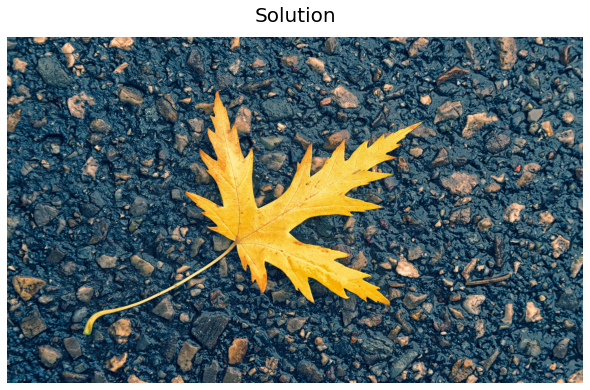

In [ ]:
image = cv.imread(input_image)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

piece_size = pixel_size

print("\n=== Population:  {}".format(POPULATION))
print("=== Generations: {}".format(GENERATIONS))
print("=== Piece size:  {} px".format(piece_size))

# Let the games begin! And may the odds be in your favor!
start = time()
algorithm = GeneticAlgorithm(image, piece_size, POPULATION, GENERATIONS)
solution = algorithm.start_evolution(verbose)
end = time()

print("\n=== Done in {0:.3f} s".format(end - start))

solution_image = solution.to_image()
solution_image_name = input_image.split(".")[0] + "_solution.jpg"

cv.imwrite(solution_image_name, solution_image)
print("=== Result saved as '{}'".format(solution_image_name))

print("=== Close figure to exit")
show_image(solution_image, "Solution")

# 2400

In [ ]:
create_puzzle("leaf.jpg", "puzzle.jpg", 100)

['Puzzle created with 2400 pieces']


In [ ]:
# -------INPUT--------- #
input_image = "puzzle.jpg"
pixel_size = 100
GENERATIONS = 15
POPULATION = 600
verbose = 1


def show_image(img, title):
    Plot(img, title)
    plt.show()


=== Population:  600
=== Generations: 15
=== Piece size:  100 px
=== Pieces:      2400



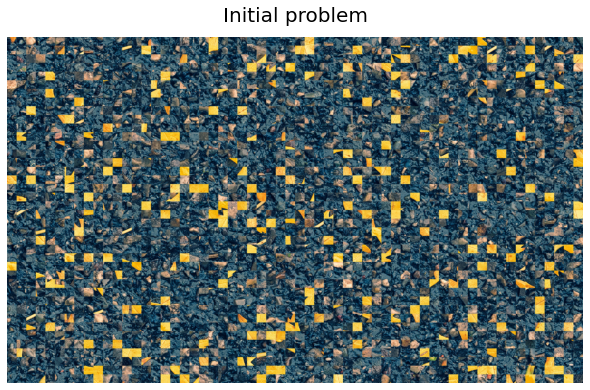

=== Analyzing image: ██████████████████████████████████████████████████ 100.0% 
=== Solving puzzle:  -------------------------------------------------- 0.0% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████---------------------------------------------- 7.1% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████------------------------------------------- 14.3% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████--------------------------------------- 21.4% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████------------------------------------ 28.6% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████-------------------------------- 35.7% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████----------------------------- 42.9% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████████------------------------- 50.0% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████████████--------------------- 57.1% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████████████████████████████████------------------ 64.3% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████████████████████████████████████-------------- 71.4% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████████████████████████████████----------- 78.6% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████████████████████████████████████------- 85.7% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████████████████████████████████---- 92.9% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████████████████████████████████████ 100.0% 


<Figure size 432x288 with 0 Axes>


=== Done in 1035.927 s
=== Result saved as 'puzzle_solution.jpg'
=== Close figure to exit


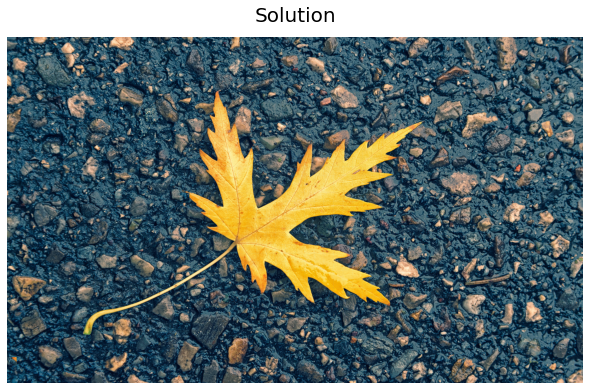

In [ ]:
image = cv.imread(input_image)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

piece_size = pixel_size

print("\n=== Population:  {}".format(POPULATION))
print("=== Generations: {}".format(GENERATIONS))
print("=== Piece size:  {} px".format(piece_size))

# Let the games begin! And may the odds be in your favor!
start = time()
algorithm = GeneticAlgorithm(image, piece_size, POPULATION, GENERATIONS)
solution = algorithm.start_evolution(verbose)
end = time()

print("\n=== Done in {0:.3f} s".format(end - start))

solution_image = solution.to_image()
solution_image_name = input_image.split(".")[0] + "_solution.jpg"

cv.imwrite(solution_image_name, solution_image)
print("=== Result saved as '{}'".format(solution_image_name))

print("=== Close figure to exit")
show_image(solution_image, "Solution")

# 3072

In [ ]:
create_puzzle("pexelimage1.jpg", "puzzle.jpg", 64)

['Puzzle created with 3072 pieces']


In [ ]:
# -------INPUT--------- #
input_image = "puzzle.jpg"
pixel_size = 64
GENERATIONS = 15
POPULATION = 600
verbose = 1


def show_image(img, title):
    Plot(img, title)
    plt.show()


=== Population:  600
=== Generations: 15
=== Piece size:  64 px
=== Pieces:      3072



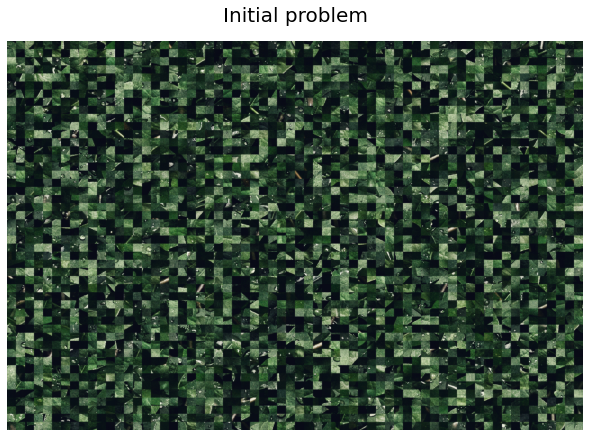

=== Analyzing image: ██████████████████████████████████████████████████ 100.0% 
=== Solving puzzle:  -------------------------------------------------- 0.0% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████---------------------------------------------- 7.1% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████------------------------------------------- 14.3% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████--------------------------------------- 21.4% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████------------------------------------ 28.6% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████-------------------------------- 35.7% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████----------------------------- 42.9% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████████------------------------- 50.0% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  █████████████████████████████--------------------- 57.1% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████████████████████████████████------------------ 64.3% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ████████████████████████████████████-------------- 71.4% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████████████████████████████████----------- 78.6% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ███████████████████████████████████████████------- 85.7% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████████████████████████████████---- 92.9% 

<Figure size 432x288 with 0 Axes>

=== Solving puzzle:  ██████████████████████████████████████████████████ 100.0% 


<Figure size 432x288 with 0 Axes>


=== Done in 2780.123 s
=== Result saved as 'puzzle_solution.jpg'
=== Close figure to exit


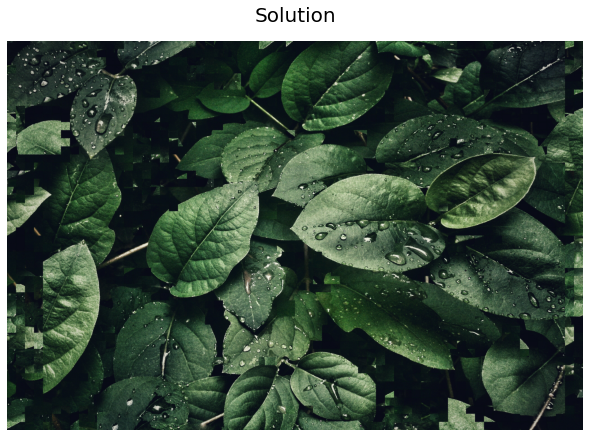

In [ ]:
image = cv.imread(input_image)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

piece_size = pixel_size

print("\n=== Population:  {}".format(POPULATION))
print("=== Generations: {}".format(GENERATIONS))
print("=== Piece size:  {} px".format(piece_size))

# Let the games begin! And may the odds be in your favor!
start = time()
algorithm = GeneticAlgorithm(image, piece_size, POPULATION, GENERATIONS)
solution = algorithm.start_evolution(verbose)
end = time()

print("\n=== Done in {0:.3f} s".format(end - start))

solution_image = solution.to_image()
solution_image_name = input_image.split(".")[0] + "_solution.jpg"

cv.imwrite(solution_image_name, solution_image)
print("=== Result saved as '{}'".format(solution_image_name))

print("=== Close figure to exit")
show_image(solution_image, "Solution")